In [3]:
'''
Updated on Mar 11 2020
'''
import pandas as pd
import numpy as np
import tejapi
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
tejapi.ApiConfig.api_key = "your key"

In [4]:
#設定要查詢的年度
query_years = [2018,2019,2020]
#產生要查詢的年度的第四季財報日 年後面加上12-01
query_year_end = [str(query_years[i])+'-12-01' for i in range(0,len(query_years))]
acc_code_name = tejapi.get('TWN/AIACC')
query_col = ['coid','eyy','mdate', 'mt_div', 'edexdate']
#查詢股東會資料
equity_data = tejapi.get('TWN/AMT',eyy=query_years,opts={'columns':query_col}, paginate=True)
#所有有股東會資料的股票代碼
all_stk_list = equity_data.loc[np.isnan(equity_data['mt_div'])!=True,'coid'].unique().tolist()

In [5]:
#用來把每股盈餘與每股股利資料合併儲存到all_fin，key值是股票，下一層是各年度以list存
all_fin = {}
for stk_id in all_stk_list:
    this_drate = []
    this_data = equity_data[(equity_data['coid']==stk_id)&(np.isnan(equity_data['mt_div'])!=True)].sort_values(by=['mdate'],ascending =False).reset_index()
    fin_data = tejapi.get('TWN/AIM1A',mdate=query_year_end,coid=stk_id,acc_code='R535',opts={'columns':['mdate','acc_value']})
    this_data['eyy'] = pd.to_datetime(this_data['eyy'])
    this_data['mdate'] = pd.to_datetime(this_data['mdate'])
    fin_data['mdate'] = pd.to_datetime(fin_data['mdate'])
    # 
    if len(fin_data)==3 and len(this_data['eyy'].unique())==3:
        all_dyield = []
        for yyyy in query_years:
            this_dyield = this_data.loc[this_data['eyy']==str(yyyy),['eyy','mdate', 'mt_div']].values.tolist()[0]
            this_eps = fin_data.loc[fin_data['mdate']==str(yyyy)+'-12-01 00:00:00+00:00','acc_value'].values.tolist()[0]
#            print(str(yyyy)+":"+stk_id+":"+str(this_eps))
            this_dyield.append(this_eps)
            all_dyield.append(this_dyield)
        all_fin[stk_id] = all_dyield

In [6]:
#用來從all_fin中判斷各股票的行為型別
last_year_div_alltype = {'p_p':[],'p_m':[],'m_p':[]}
for stk_id in all_fin:
    for i in range(0,3):
        this_data = all_fin.get(stk_id)[i]
        if this_data[2]>0 and this_data[3]<0:
            #發股息，可是虧錢
            last_year_div_alltype['p_m'].append(stk_id)
            break
        elif this_data[2]>0 and this_data[3]<this_data[2]:
            #沒虧錢，可是股息發比盈餘多
            last_year_div_alltype['m_p'].append(stk_id)
            break
    last_year_div_alltype['p_p'].append(stk_id)
print(last_year_div_alltype['p_m'])

['1528', '2062', '2448', '3432', '3591', '3708', '4306', '5452', '6120', '6235', '8046', '9919']


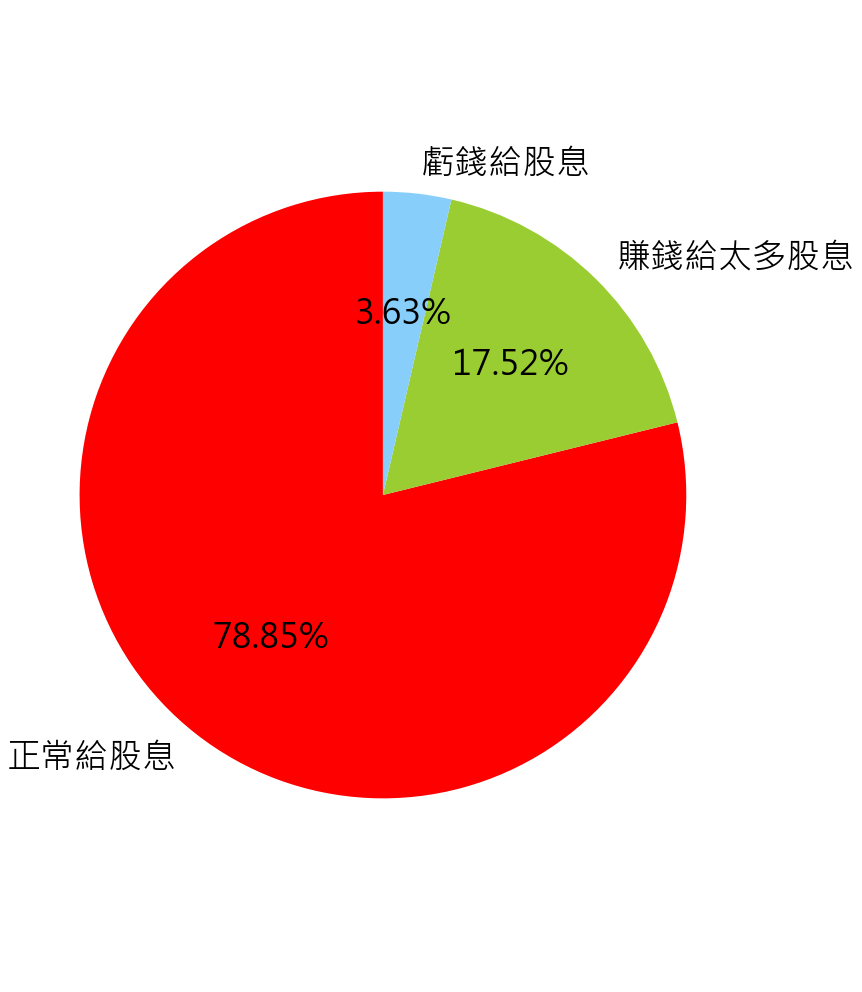

In [7]:
#印出圓餅圖
import matplotlib as mpl
mpl.rcParams['font.size'] = 34.0
plt.rcParams['font.sans-serif']=['microsoft jhenghei'] 
plt.figure(figsize=(12,18)) 
labels = ['正常給股息','賺錢給太多股息','虧錢給股息'] 
sizes = [len(last_year_div_alltype['p_p']),len(last_year_div_alltype['m_p']),len(last_year_div_alltype['p_m'])] #每块值
colors = ['red','yellowgreen','lightskyblue'] 
explode = (0,0,0) 
patches,text1,text2 = plt.pie(sizes,explode=explode,labels=labels,colors=colors,autopct = '%3.2f%%', shadow = False,startangle =90, pctdistance = 0.6)
plt.axis('equal')
plt.show()